# Hypothesis Testing: Data Science Salary Comparision in Two Different Regions

## 1. Introduction

**1.1 Background Information About Salaries in Data Science Job**

Data science is undoubtedly one of the most lucrative career options. However, it's crucial to recognize that salary can vary significantly based on factors such as location and company (Situ et al., 2017). Therefore, it's essential to weigh all aspects when choosing between different offer (Robinson et al., 2020). Hence, analyzing the difference in salary between different regions could provide employees some insights to choose a place to start their journey in data science. 

**1.2 About Our Project**

Research Question: Is there a difference of the salary of jobs that related to data science in Europe and North America?

More specifically, we will focus on the disparity in data science job salaries between two different regions, Europe and North America. Our response variable is the data science job salary, and we will use the difference in **mean** salary and **standard deviation** of the salary to evaluate the question. To construct the hypothesis test, we will employ both bootstrapping and asymptotic methods.

**1.3 About The Dataset**

Our dataset was found from Kaggle, which includes information regarding the data science jobs’ salaries in different locations during the 2020-2022 work year. These data were scraped by Ruchi Bhatia from https://salaries.ai-jobs.net/ (Bhatia, 2022). Here, we provides variables that are related to our study.

Variables:

1. company_location - The country of the employer's main office.
2. location - Regions where employees work (created based on company_location, either Europa or North America)
3. salary_in_usd - The salary in USD


## 2. Preliminary Results

**2.1 Data Cleaning**

In [2]:
# load necessary packages
library(infer)
library(tidyverse)
library(cowplot)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
raw_salary <- read.csv("https://raw.githubusercontent.com/YuluDuan/Hypothesis-Testing-Data-Science-salary-comparison-in-different-location/main/ds_salaries.csv")

head(raw_salary)

,X,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
3,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
4,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
5,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
6,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


In this project, as we would focus on analyzing the salary in both Europe and North America, it is important to first filter out all the data that belongs to that two countries and select the necessary column (i.e. location and salary_in_usd).

In [4]:
# by checking all the countries in this list, first find out the countries that belongs to Europe and North America.

na <- c("US", "MX","CA")
eur <- c("DE", "GB", "HU", "FR", "GR", "NL", "AT", "ES", "PT", "DK", "IT", "HR", "LU"
         ,"PL", "RO", "BE", "UA", "RU", "MT", "MD", "SI", "CH", "CZ", "EE", "IE")

In [5]:
# fliter out all rows belong to Europe and North America, save them to a new column called "location"

ds_salary <- raw_salary %>%
    filter(company_location %in% append(na, eur)) %>%
    mutate(location = "North America")

ds_salary$location[ds_salary$company_location %in% eur] <- "Europe"

ds_salary$location <- as.factor(ds_salary$location)

In [6]:
# create the final data set for this project by selecting columns that we would be useful.
ds_final <- ds_salary %>%
    select(salary_in_usd, location)
head(ds_final) # overview of the data

,salary_in_usd,location
,<int>,<fct>
1,79833,Europe
2,109024,Europe
3,150000,North America
4,72000,North America
5,190000,North America
6,35735,Europe


Here, we get our final dataset that would be used to data analysis, and we would now provide overview of the data by providing summary and plots. 

**2.2 Data Summary and Visualization**

Firstly, we would provide summary of the salaries, mainly the sample size for each region, and 5-number-summary for them.
From the table, we get our estimates of mean population salary in two groups. For Europe, the sample mean salary is 69358.37. For North America, the sample mean salary is 139769.85. 

* Table 1. Summary of the wages in two different locations

In [7]:
# create the summary of the data by setting a table with information about salary
ds_eur <- ds_final %>%
    filter(location == "Europe")
ds_na <- ds_final %>%
    filter(location == "North America")

summary_eur <- summary(ds_eur$salary_in_usd)
summary_na <- summary(ds_na$salary_in_usd)

location <- c("Europe", "North America")
mini <- c(summary_eur[1], summary_na[1])
quan_1 <- c(summary_eur[2], summary_na[2])
median <- c(summary_eur[3], summary_na[3])
mean <- c(summary_eur[4], summary_na[4])
quan_3 <- c(summary_eur[5], summary_na[5])
max <- c(summary_eur[6], summary_na[6])
sample_size <- summary(ds_final$location)

table1 <- data.frame(minimum_wage = mini, first_quantile = quan_1, 
                     median_wage = median, mean_wage = mean, third_quantile = quan_3, maximum_wage = max, sample_size)
table1

,minimum_wage,first_quantile,median_wage,mean_wage,third_quantile,maximum_wage,sample_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Europe,5882,46597.0,63831,69358.37,87932,230000,157
North America,2859,99037.5,130400,139769.85,170000,600000,388


Now we would want to create the histogram of salary for both regions to help us understand the distribution.

* Figure 1: Histograms of Salary in Europe and North America

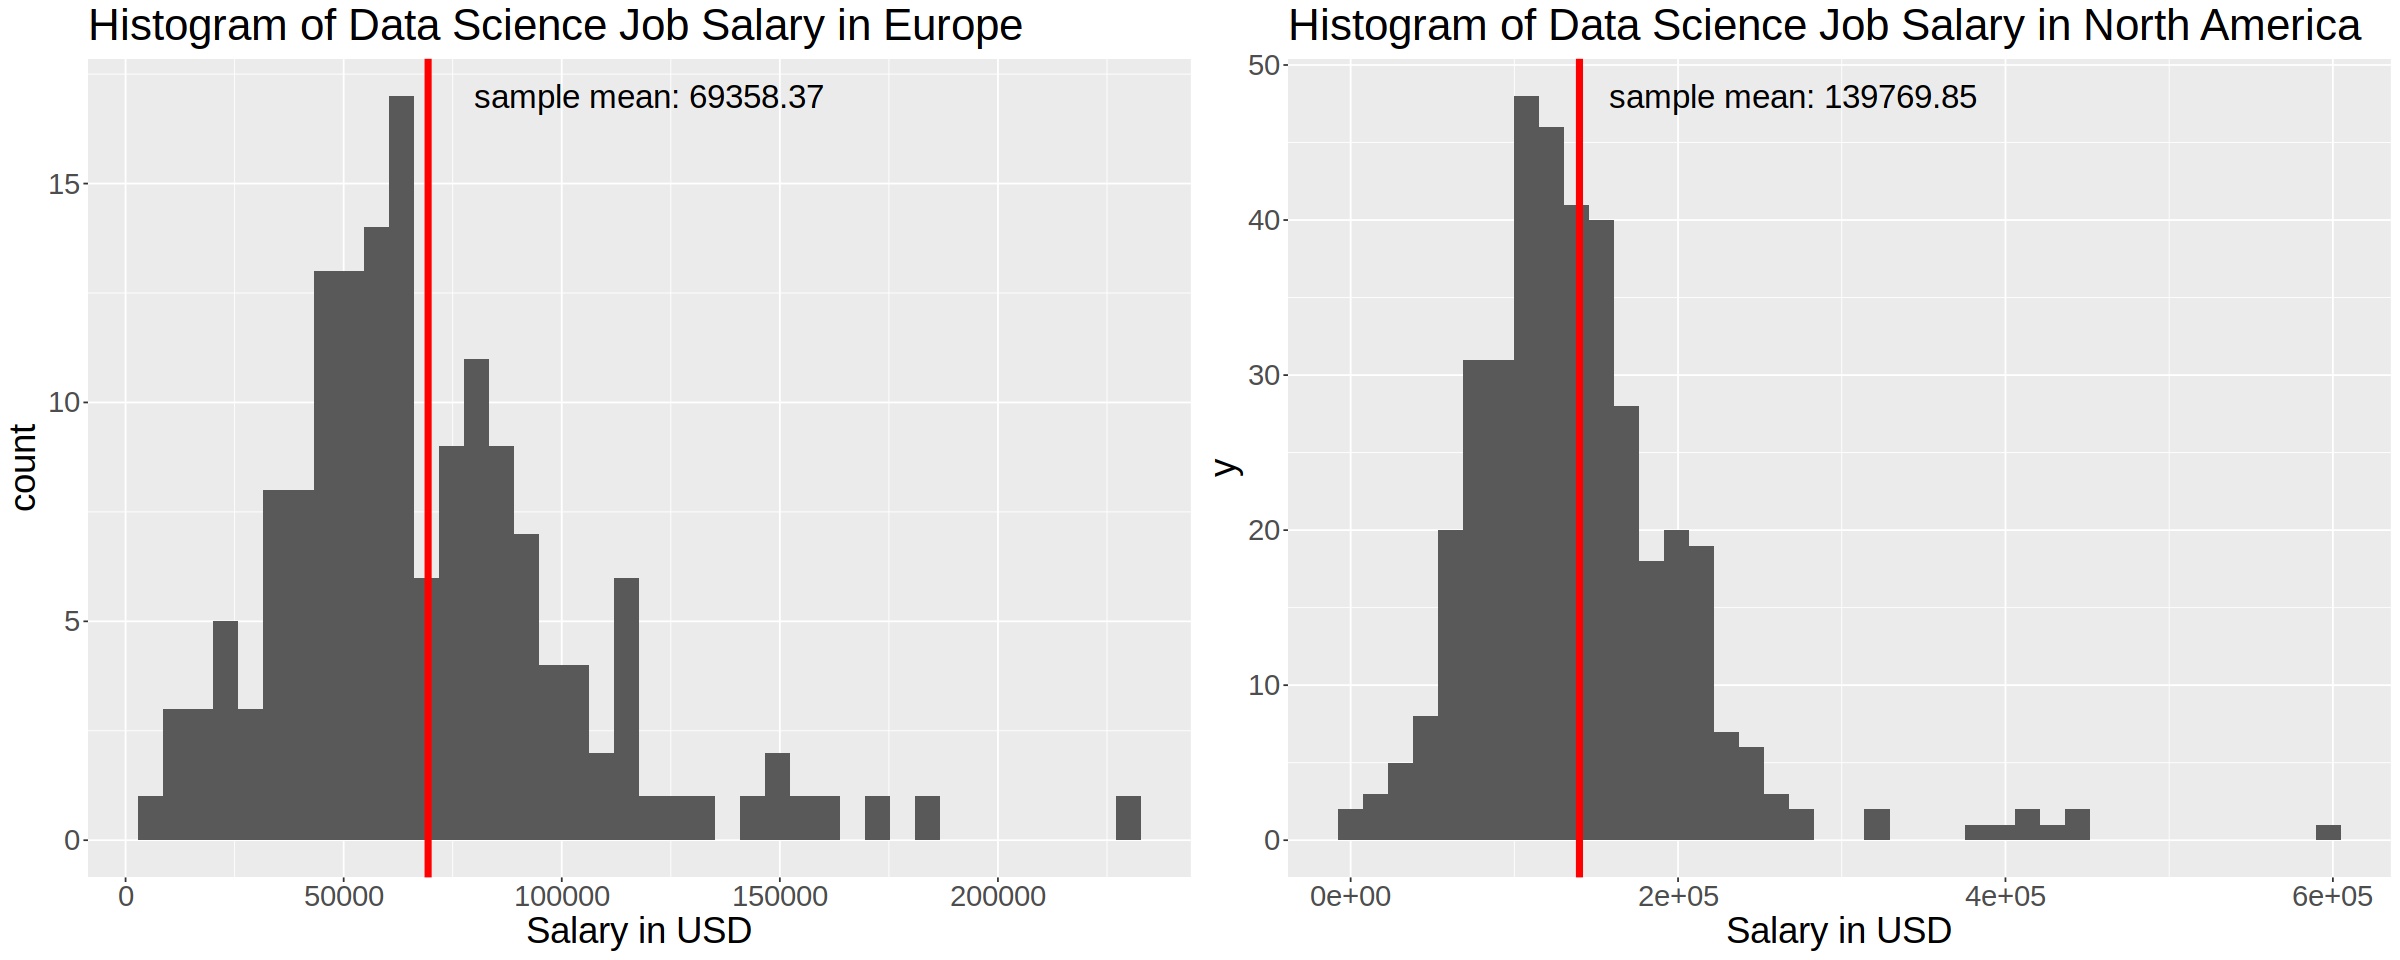

In [42]:
## create the two distributions

options(repr.plot.width= 20, repr.plot.height=8)
histogram_europe <- ds_final %>%
    filter(location == "Europe") %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(bins = 40) +
    theme(text = element_text(size = 22)) +
    xlab("Salary in USD") + 
    ylab("count")+
    ggtitle("Histogram of Data Science Job Salary in Europe") + 
    geom_vline(xintercept = table1$mean_wage[1], color = "red", size = 2) + #add the line of sample mean
    annotate("text", x = 120000, y = 17, label = "sample mean: 69358.37", size = 7) 

histogram_na <- ds_final %>%
    filter(location == "North America") %>%
    ggplot(aes(x = salary_in_usd),color = 'white') +
    geom_histogram(bins = 40) +
    theme(text = element_text(size = 22)) + 
    xlab("Salary in USD") + 
    ggtitle("Histogram of Data Science Job Salary in North America") +
    geom_vline(xintercept = table1$mean_wage[2], color = "red", size = 2) + #add the line of sample mean
    annotate("text", x = 270000, y = 48, label = "sample mean: 139769.85", size = 7) 

plot_grid(histogram_europe, histogram_na, labels = c('', ''))

For hypothesis testing, solely looking at the 5-number-summary is not enough as there is also variability in our data. Hence, it would be helpful to pay attention to the spread of salaries for each region, which we can compare by side-by-side boxplot.

* Figure 2: Boxplot of the salaries in two different regions

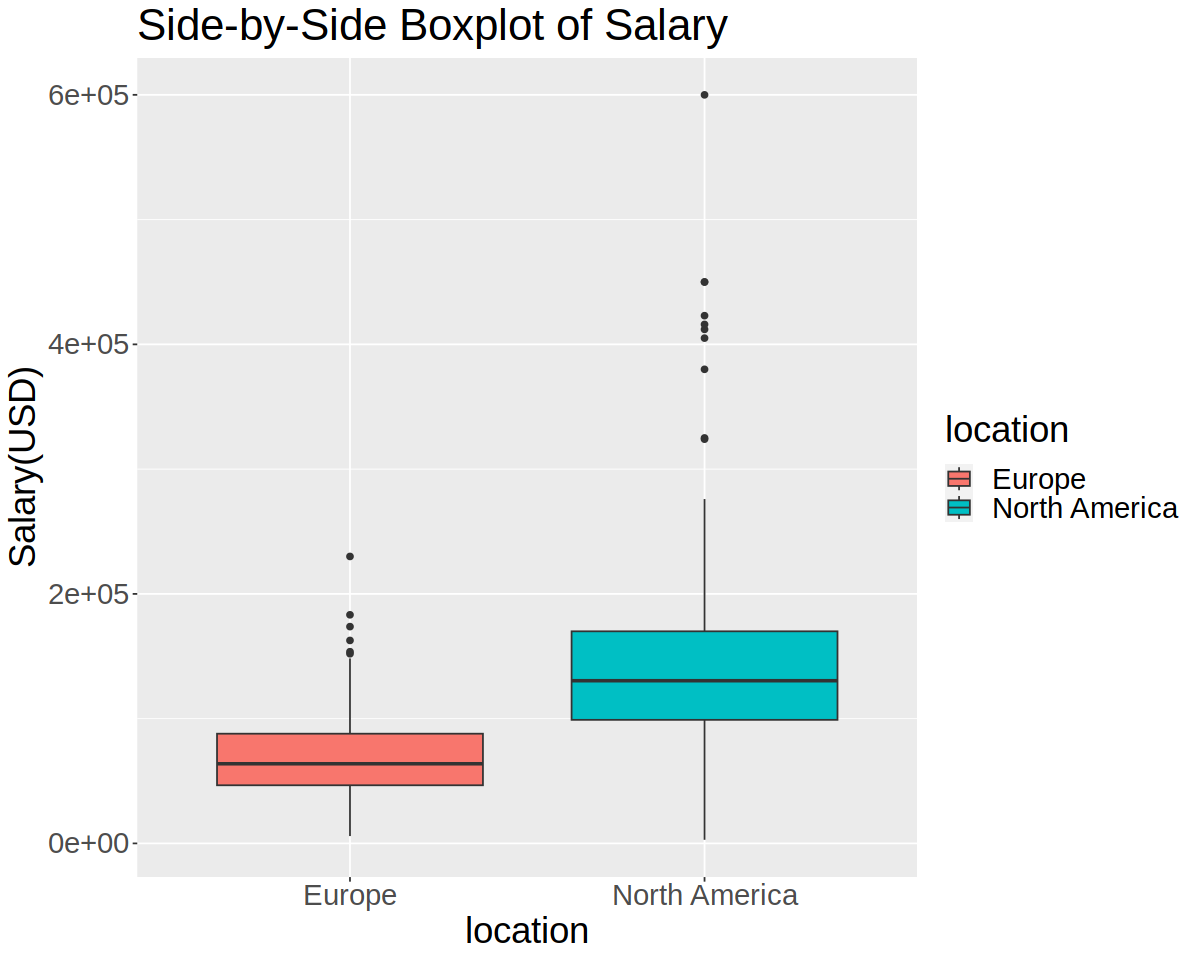

In [43]:
options(repr.plot.width=10, repr.plot.height=8)
boxplot_ds <- ggplot(ds_final, aes(x = location, y = salary_in_usd, fill = location)) +
    geom_boxplot() +
    theme(text = element_text(size = 22)) +
    ylab("Salary(USD)") +
    ggtitle("Side-by-Side Boxplot of Salary")
    
boxplot_ds

## 3. Methods: Plan

**3.1 Potential Strength of the Data**

The sample would be useful in learning about the current data science job markets since it comes from real data science jobs in recent years. Also, the sample sizes are fairly large, providing a higher chance for the data to be representive. But one point is worth-noting. As there is no clear information whether the data is from a random sample, we have to make this assumption when performing our analysis.

**3.2 Method and Plan**

To answer our question, we would takes a close look at the two sample means and connect them to the sample standard deviations. It would be insufficient to solely look at the plots and estimates since there is sampling variability we need to consider. Thus, we would provide confidence interval for the test statistic of difference in sample means (sample mean salary in North America minus the one in Europa to quantify the errors of the estimate. Also, we would use hypothesis testing with null hypothesis (H0) being there is no difference in the true mean salary between data science jobs in North American and Europe, and alternative hypothesis (Ha) being there is a difference in the true mean salary between these two regions.


Meanwhile, we would use both Bootstrap\Simulation and Asymptotic Method. We will take multiple samples with replacement from the original sample to form bootstrap distribution for confidence interval, and use permutation to get the null model for hypothesis testing. To conduct an asymptotic test, we will first check assumptions and find the confidence interval and perfrom the two-sample t-test based on CLT. At the end, we would compare the two results.


**3.3 Expected results and Impact**

Based on Preliminary Results, we expect to reject the null hypothesis and in favor that there is a difference in the mean salary of the two regions. Because the boxplot shows that 75% of sampled salaries in North America are greater than third quantile of the sampled salaries in Europe. Also, we think the bootstrap and asymptotic method should do similar job since we have relative large sample size and the sample distributions does not deviate that much from normal. We believe this result might help new graduates to decide the location to start their data science journey. Since there are also other factors, like company size, associate with salaries; in future, we could do more analysis to see how other factors could inflence the data science jobs' salaries.

## 4. References

Bhatia, R. (2022). Data Science Job Salaries. Kaggle. https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

Robinson, E., Nolis, J., & O'Reilly for Higher Education. (2020). Build a career in data science. Manning Publications Co.

Situ, W., Zheng, L., Yu, X., & Daneshmand, M. (2017). Predicting the probability and salary to get data science job in top companies. IIE Annual Conference. Proceedings, 933-939.
